#### <center>[yager.io](https://yager.io)</center>
# <center>Training Neural Audio Effects</center>


I'm starting a new job at an AI lab soon, working on engineering for RL systems, and I want to do a bit of hands-on NN work to get a sense for what a notebook research workflow might look like, since a bunch of my coworkers will be using this workflow.

Let's figure out how to train a model to emulate various audio effects, like distortion effects or reverbs.

I've not read much neural network literature at this point. Basically everything I know about NNs is just from discussions with [my friend who works on neural compression codecs](https://danjacobellis.net). I'll probably do some stupid stuff here, call things by the wrong name, etc., but I find it's often more educational to go in blind and try to figure things out yourself. I'm also only vaguely familiar with pytorch; my mental model is that it's a DAGgy expression evaluator with autodiff. Hopefully that's enough to do something useful here.

I figure an architecture that might work pretty well is to have the previous `m` input samples, $[i_n, i_{n+1}, ..., i_{n+m-1}, i_{n+m}]$, and the previous `m-1` output samples, $[o_n, o_{n+1}, ..., o_{n+m-1}]$, and train the network to generate the next output sample, $o_{n+m}$

```
                     .-------.
[m prev inputs]----->|  The  |
[m-1 prev outputs]-->| Model |-->[next output]
                     '-------'
```

This architecture seems good to me because:

1. It's easy to generate examples of input data where we can train the model 1 sample at a time
2. It gives the model enough context to (theoretically) recover information like "what is the current phase of this oscillator"


As for how to actually represent the audio, some initial thoughts:

1. You could just pass in and extract straight up $[-1,1]$ float audio into/out of the model.
   1. The model will have to grow hardware to implement a threshold detector ADC or something, which seems kind of wasteful
   2. This fails to accurately capture entropy density in human audio perception. A signal with peak amplitude 0.01 is often just as clear to humans as a signal with peak amplitude 1.0. Which brings us to a possible improvement
2. Pre- and post-process the audio with some sort of compander, like a $\mu$-law
   1. This will probably help the model maintain perceptual accuracy across wide volume ranges
3. Encode a binary representation of the audio. This feels to me like it will probably be difficult for the model to reason about.
4. Use some sort of one-hot encoding for the amplitude, probably in combination with a companding algorithm. This might be too expensive on the input side (since we have a lot of inputs), but could work well on the output side. We could have 256 different outputs for 8-bit audio, for example.
   1. We could also possibly allow the network to output a continuous "residual" value for adding additional accuracy on top of the one-hot value.
  
For now, let's just try the first thing and see how it goes. I expect it will work OK for well-normalized (loud) audio and poorly for quiet audio.

As for our loss function: probably some sort of perceptual similarity metric would be best, followe by a super simple perceptual-ish metric like squared error in $\mu$-law space. However, to start with, let's just do linear mean squared error. Should be OK for loud audio.

First up, I need a bunch of training data. I took a bunch of songs from my music library and put them in the `examples` folder. (I'm old enought that I have about 75GB of local music files.) 

When we want to train a new effect, we'll have a bunch of training runs of the form:

1. Pick a bunch of random song slices from the library
2. Feed the song slices through the reference implementation of the effect (could be software or hardware)
3. Train the model to predict the next sample of the effect across all I/O examples in the batch

## Initial Setup: Loading example audio, slicing example data

Feel free to scroll past this section. If I could figure out how to make jupyter export collapse this, I would

In [1]:
import os
import numpy as np
from scipy import signal
import torchaudio
import random
from pathlib import Path
from typing import List, Tuple

# List all the audio files in a directory
def list_audio_files(examples_dir: str = "examples") -> List[str]:
    # m4a doesn't work for some reason
    audio_extensions = {'.mp3','.wav', '.flac', '.aac', '.ogg', '.mp4'}
    audio_files = []
    examples_path = Path(examples_dir)
    for file_path in examples_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in audio_extensions:
            audio_files.append(str(file_path))
    return sorted(audio_files)

# Read audio file to normalized mono float32 array
def read_audio_normalized(file_path: str) -> np.ndarray:
    waveform, sample_rate = torchaudio.load(file_path)
    audio = waveform.numpy().astype(np.float32)
    if audio.shape[0] > 1:
        audio = np.mean(audio, axis=0)
    else:
        audio = audio.squeeze(0)
    peak = np.max(np.abs(audio))
    if peak > 0:  # Avoid division by zero for silent audio
        audio = audio / peak
    return audio

OK, now let's write some code to generate input/output data for training the network.

Our input tensor will be of shape `(batch size, m input samples + m-1 output samples)` and our output tensor will
be of shape `(batch size, 1)`.

First, load some example audio:

In [2]:
from IPython.display import clear_output

# Pick some random audio files from disk and load into memory
def load_some_audio_files(file_count : int) -> List[np.ndarray]:
    audio_files = list_audio_files()
    assert(len(audio_files) >= file_count)
    selected_files = random.sample(audio_files, file_count)
    audios = []
    for file_path in selected_files:
        try:
            dry_audio = read_audio_normalized(file_path)
            audios.append(dry_audio)
        except Exception as e:
            print(f"Warning: Failed to process {file_path}: {e}")
    return audios

dry_audio = load_some_audio_files(128)

# We get a bunch of spam about our loader seeing format issues in certain files. Not important
clear_output()

Then, a function that takes unprocessed/processed examples and slices them up into lots of little slices for the model to train on:

In [3]:
# Generate lots of short training examples from our processed songs
def generate_slices_from_pairs(
    # Long dry/wet audio samples. Entire clean and processed songs
    audio_pairs: List[Tuple[np.ndarray, np.ndarray]],
    # How much input/output history we should give the model in each example
    context_window: int,
    # How many short slices we should make per long dry/wet sample
    slices_per_pair: int
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given reference input/output dry/wet audio pairs,
    create numpy arrays suitable for training the neural network.
    Will generate randomly-selected slices from each audio pair.

    Returns:
        Tuple of (input_features, target_outputs):
        - input_features: f32 array of shape (total_slices, context_window * 2 - 1)
            Each row contains `context_window` input samples concatenated with 
            `context_window - 1` previous output samples
        - target_outputs: f32 array of shape (total_slices, 1)
            The next output sample corresponding to each input block
    """
    total_slices = len(audio_pairs) * slices_per_pair
    feature_size = context_window * 2 - 1
    
    input_features = np.zeros((total_slices, feature_size), dtype=np.float32)
    target_outputs = np.zeros((total_slices, 1), dtype=np.float32)
    
    slice_idx = 0
    
    for dry_audio, wet_audio in audio_pairs:
        if len(dry_audio) < context_window + 1:
            print(f"Warning: Audio pair too short ({len(dry_audio)} samples), need at least {min_length}. Skipping.")
            continue
        
        slice_positions = np.random.randint(context_window, len(dry_audio), size=slices_per_pair)
        
        for pos in slice_positions:
            # Extract input context: previous context_window input samples
            input_context = dry_audio[pos - context_window:pos]
            
            # Extract output context: previous context_window-1 output samples  
            output_context = wet_audio[pos - context_window:pos - 1]
            
            # Combine input and output contexts
            input_features[slice_idx] = np.concatenate([input_context, output_context])
            
            # Target is the next output sample
            target_outputs[slice_idx, 0] = wet_audio[pos]
            
            slice_idx += 1
    
    # Trim arrays if some pairs were skipped
    input_features = input_features[:slice_idx]
    target_outputs = target_outputs[:slice_idx]
    print(f"Generated {slice_idx} slices from {len(audio_pairs)} audio pairs")
    return input_features, target_outputs

## The Model

Let's define a model with an input layer, 5 middle layers, and an output layer that maps down to a scalar. GELU between layers.

In [4]:
import torch
import matplotlib.pyplot as plt
from typing import Self

# Each inner layer is this wide
inner_layer_size = 256
num_inner_layers = 5

class Model:
    def __init__(self, input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias, device):
        self.input_layer, self.input_biases, self.inner_layers, self.inner_biases, self.output_layer, self.output_bias = \
            input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias
        self.device = device
    # Run the model forward
    def eval(self, inputs):
        vec = torch.nn.functional.gelu(inputs @ self.input_layer + self.input_biases)
        for i,layer in enumerate(self.inner_layers):
            bias = self.inner_biases[i]
            vec = torch.nn.functional.gelu(vec @ layer + bias)
        vec = vec @ self.output_layer + self.output_bias
        return vec
    # Move the model to a different device
    def to(self, device) -> Self:
        return Model(
           self.input_layer.to(device),
           self.input_biases.to(device),
           [l.to(device) for l in self.inner_layers],
           [l.to(device) for l in self.inner_biases],
           self.output_layer.to(device),
           self.output_bias.to(device),
           device)
    
# Run a model on CPU audio
# This is janky; in production, I would send an N-sample buffer of input audio to the device (whether CPU or GPU)
# and do the iterative model evaluation there, instead of going back-and-forth on every sample.
# For now, we can just move the model to the CPU and inference is acceptably fast for this notebook
def apply_to_audio(model : Model, audio):
    inputs = np.zeros(context_window).astype('float32')
    prev_outs = np.zeros(context_window - 1).astype('float32')
    outputs = np.zeros(audio.shape).astype('float32')
    for i,sample in enumerate(audio):
        # Shift on the new input sample
        inputs[:-1] = inputs[1:]
        inputs[-1] = sample
        model_input = np.concatenate([inputs, prev_outs])
        with torch.no_grad():
            output = model.eval(torch.from_numpy(model_input).to(model.device)).item()
        # Shift on the new output sample (which we just generated)
        prev_outs[:-1] = prev_outs[1:]
        prev_outs[-1] = output

        # Save the output
        outputs[i] = output
    return outputs

## Training the Model

### Issues Encountered During Training

There are 2 issues I ran into that took a bit of debugging to figure out. I initially wanted to present them in the same narrative order that I discovered them, but annoyingly, re-running the notebook often makes them show up in a different place (or not at all), so I'll just describe them here

#### Issue 1: Deep GELU blowup

An issue I ran into during initial training runs: if you pick a bunch of gaussian initial weights, and each layer is a GELU, you get a bunch of paths through the network where the expected "gain" is extremely large, probably on the order of something like `sqrt(width)^depth` if I had to guess, resulting in insanely large outputs that take a lot of training bandwidth to eliminate (at least with the Adam optimizer). I just normalized the weights by `1/sqrt(width)`, which made the training converge quite quickly without having to tamp down excessive outputs.

I imagine some of the "norm" operations I sometimes hear about are used to address this. In any case, the careful selection of initial weights seems to work fine.

#### Issue 2: Feedback Error Instability

Initially I trained the model like

```python
training_data = ... # Generate lots of mathematically exact example input/output pairs
model = train(training_data, epoch_count = 100)
```

which *often* worked, but some fraction of the time, the model would grow to exhibit eventual oscillatory instability. It would tightly track the correct value for a while (perhaps a few thousand samples), but would eventually start to oscillate about the correct value like this:

![Oscillatory behavior](./oscillation.png)

Given that the validation loss during training looked so good, the most plausible theory I could think of here was that the model was growing a (not-strictly-necessary) dependency on the feedback pathway. E.g. it may have been relying on `in[t-1] - out[t-1]`. During training, these two values would have been generated by our `tanh` distortion algorithm, not by the model, and so it would have had an exact mechanical relationship that the model could perhaps take advantage of. 

However, during inference, all of the `out` values are generated by the model itself, not by our `tanh` distortion function. So, if the model makes a slight error in predicting an output value, this error will get cycled back into the model during the next inference step, and the error could compound or oscillate as we see here.

To fix this, we need to teach the model that the $[o_n, o_{n+1}, ..., o_{n+m-1}]$ buffer of previous output values we're feeding it is not totally trustworthy; since these values are generated by the model during inference, they will have some error.

The simple fix I came up with was to **inject some noise into the feedback pathway during training**. The noise in the feedback pathway simulates the error that the model introduces. To perform well, the model needs to learn to treat the feedback audio as only approximate, which makes it robust against feedback error. This worked great, totally eliminating the dynamic instability.

In [21]:
def add_feedback_noise(examples : Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Add some noise to the "previous output" buffer to simulate error on the part of the network during inference.
    This avoids the creation of unstable feedback loops.
    """
    (inputs, outputs) = examples
    inputs = inputs.copy()
    inputs[:,context_window:] += np.random.randn(inputs.shape[0], context_window - 1) / 10.0
    return (inputs, outputs)

### The Good Stuff

Now that we have the issues out of the way, let's get to the actual training.

In [5]:
# This was revealed to me in a dream
batch_size = 1024*16

# See above comment - avoiding deep GELU blowup
weight_norm = 1.0/np.sqrt(inner_layer_size)

# Just take the linear MSE of the output vs the reference
def linear_loss(output, reference):
    error = output - reference
    loss = (error ** 2).mean()
    return loss

# Turn a bunch of examples into a model
def train(examples : Tuple[np.ndarray, np.ndarray], epoch_count : int = 100, loss_function = linear_loss) -> Model:
    """
    Train a model on the given input/output examples

    Args:
        examples[0]: A (batch_size, context_window*2-1) tensor of (m prev input, m-1 prev output) pairs
        examples[1]: A (batch_size, 1) tensor of next audio output values
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (GPU) device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")
    # Losses of each epoch
    training_losses = []
    # Loss on the holdout validation data
    validation_losses = []

    # Move data to GPU, separate out the holdout validation data
    inputs, outputs = examples
    inputs, outputs = torch.tensor(inputs).to(device), torch.tensor(outputs).to(device)
    validation_inputs, inputs = inputs[:1000], inputs[1000:]
    validation_outputs, outputs = outputs[:1000], outputs[1000:]

    # Model parameters
    # Input layer maps from the input context to our inner layers
    input_layer = (torch.randn((context_window * 2 - 1, inner_layer_size),device=device) * weight_norm).requires_grad_()
    input_biases = (torch.randn(inner_layer_size, device=device) * weight_norm).requires_grad_()
    # Inner layers do whatever
    inner_layers = [(torch.randn((inner_layer_size, inner_layer_size), device=device) * weight_norm).requires_grad_() for _ in range(num_inner_layers)]
    inner_biases = [(torch.randn(inner_layer_size, device=device) * weight_norm).requires_grad_() for _ in range(num_inner_layers)]
    # Maps from our last layer to the next audio output value
    output_layer = (torch.randn((inner_layer_size, 1), device=device) * weight_norm).requires_grad_()
    output_bias = (torch.randn(1, device=device) * weight_norm).requires_grad_()
    model = Model(input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias, device)

    # Set up the Adam optimizer
    # I didn't really think too hard about this, just copied it from the first time I used torch and messed with lr a bit
    # My understanding is that ADAM automatically adjusts learning rate for each param, uses momentum, etc.
    optimizer = torch.optim.Adam([input_layer, input_biases] + inner_layers + inner_biases + [output_layer, output_bias], lr=0.00001)
    
    # Run a bunch of optimization steps
    for epoch in range(epoch_count):
        # Shuffle the training inputs.
        # Does this matter? Probably not. But it feels good
        num_training_samps, _ = inputs.shape
        epoch_indices = torch.randperm(num_training_samps)
        inputs = inputs[epoch_indices]
        outputs = outputs[epoch_indices]

        # Run a bunch of batches
        # Per-batch losses
        epoch_training_losses = []
        num_batches = num_training_samps//batch_size
        for batch in range(num_batches):
            batch_inputs = inputs[batch_size * batch : batch_size * (batch + 1)]
            batch_outputs = outputs[batch_size * batch : batch_size * (batch + 1)]
            # Reset the gradients on each leaf node
            optimizer.zero_grad()
            # Run the model forward
            vec = model.eval(batch_inputs)
            loss = loss_function(vec, batch_outputs)
            # Update our weights
            loss.backward()
            epoch_training_losses.append(loss.cpu().item())
            # Let the optimizer adjust the params
            # Conceptually it's basically doing param -= param.grad * 0.01 for each param
            # But it's doing stuff with momentum, normalization, etc. to make it converge faster
            optimizer.step()

        # Record the average training loss for the epoch
        training_losses.append(np.mean(epoch_training_losses))

        # Calculate the validation loss
        with torch.no_grad():
            vec = model.eval(validation_inputs)
            error = vec - validation_outputs
            loss = (error ** 2).mean()
            validation_losses.append(loss.cpu().item())

        # Update the loss graph
        clear_output(wait=True)
        plt.plot(training_losses, 'g', label = 'Training')
        plt.plot(validation_losses, 'r', label = 'Validation')
        plt.legend()
        plt.yscale('log')
        plt.show()
            
    # Move to CPU because I haven't bothered to make a non-numpy inference loop
    # It will work either way but CPU is like 10x faster with my janky inference loop
    return model.to('cpu')

We'll train the model on a "does nothing" effect that just passes through the audio unchanged. This is a good sanity check that our structure even works.

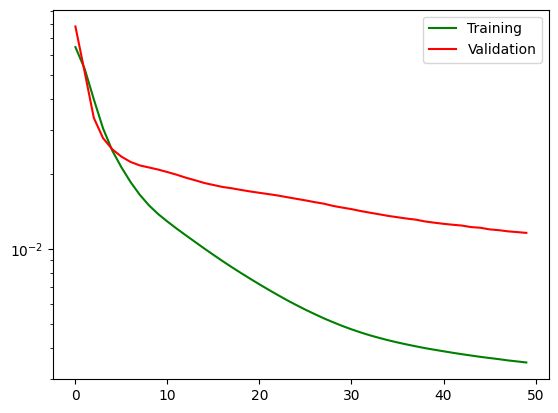

In [22]:
# For long-duration effects like reverbs, delays, or slow LFOs, we would need a longer window
context_window = 128
# Any given song should have millions of samples, so taking 128*8*1024 = ~1M samples
# from each song should give us lots of diverse example inputs.
slices_per_pair = 1024*8

# Do nothing to the audio.
# For now we're just learning how to pass audio through unchanged
passthru_data = generate_slices_from_pairs([(dry, dry) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)

# Note that I'm adding noise here to avoid the model developing unstable feedback cycles
clean_model = train(add_feedback_noise(passthru_data), epoch_count = 50)

That actually looks better than I expected with linear IO. On the order of 1% error. Let's listen to it. First, a short clip from some validation data from Emancipator's *1993*.

In [23]:
from IPython.display import Audio
import numpy as np

listen_audio = read_audio_normalized("validation/1993.wav")[:44100]

sample_rate = 44100
Audio(listen_audio, rate=sample_rate)

Let's run it through the model.

In [24]:
clean_processed = apply_to_audio(clean_model, listen_audio)
Audio(clean_processed, rate=sample_rate)

Wow, nice! That actually sounds pretty close. A little noisy, as expected. As long as we're happy with only handling loud audio, we don't even need to deal with companding or anything.

In [25]:
avg = np.abs(listen_audio).mean()
err = clean_processed - listen_audio
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.2080584615468979
Average error: 0.0059739681892097
Audio max: 0.9950575232505798
Error max: 0.11991273611783981


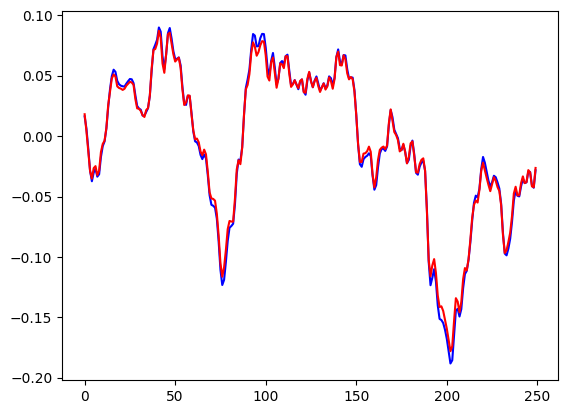

In [26]:
plt.plot(listen_audio[:250],'b', label = 'Original')
plt.plot(clean_processed[:250], 'r', label = 'Model')

## Distortion Effect

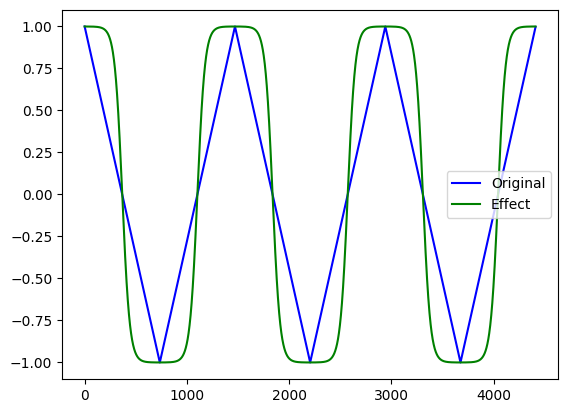

In [11]:
def distort(audio):
    return np.tanh(audio*5)
    
def triangle_wave(freq):
    time = np.arange(0,0.1,1/44100)
    return 2 * np.abs(signal.sawtooth(2 * np.pi * freq * time)) - 1
    
plt.plot(triangle_wave(30), 'b', label = 'Original')
plt.plot(distort(triangle_wave(30)), 'g', label = 'Effect')
plt.legend()

In [12]:
Audio(distort(listen_audio), rate=sample_rate)

In [13]:
distort_data = generate_slices_from_pairs([(dry, distort(dry)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)

Generated 1040384 slices from 127 audio pairs


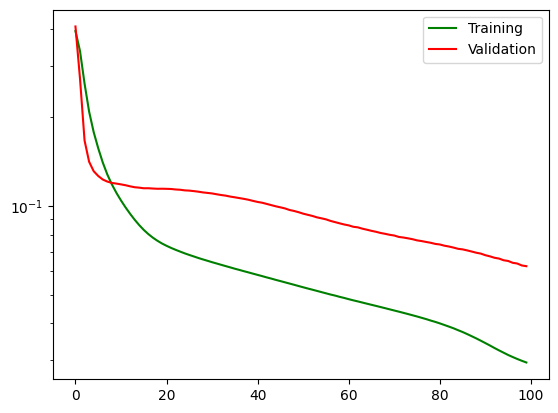

In [15]:
distort_model = train(add_feedback_noise(distort_data), epoch_count = 100)

In [16]:
distort_processed = apply_to_audio(distort_model, listen_audio)
Audio(distort_processed, rate=sample_rate)

In [18]:
avg = np.abs(distort(listen_audio)).mean()
err = distort_processed - distort(listen_audio)
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.5817455649375916
Average error: 0.03470087796449661
Audio max: 0.9950575232505798
Error max: 0.5576112270355225


In [ ]:
plt.plot(listen_audio[:500],'b', label = 'Original')
plt.plot(distort(listen_audio)[:500],'g', label = 'Effect')
plt.plot(distort_processed_2[:500], 'r', label = 'Model')
plt.legend()

## Lowpass filter effect

In [ ]:
from scipy.signal import butter, sosfilt, sosfilt_zi

def lowpass(audio, cutoff_freq, sample_rate, order=4):
    nyquist = sample_rate / 2
    normalized_cutoff = cutoff_freq / nyquist
    sos = butter(order, normalized_cutoff, btype='low', output='sos')
    zi = sosfilt_zi(sos) * audio[0]
    filtered, _ = sosfilt(sos, audio, zi=zi)
    return filtered

plt.plot(triangle_wave(50), 'b', label = 'Original')
plt.plot(lowpass(triangle_wave(50), 100, 44100), 'g', label = 'Effect')
plt.legend()

In [ ]:
lowpass_listen = lowpass(listen_audio, 1000, 44100)
Audio(lowpass_listen, rate=sample_rate)

In [ ]:
lowpass_data = generate_slices_from_pairs([(dry, lowpass(dry, 1000, 44100)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)
lowpass_data = add_feedback_noise(lowpass_data)

In [ ]:
lowpass_model = train(lowpass_data, epoch_count = 100)

Interesting - look how low the error is! My guess is that the network is benefitting from the ability to extract magnitude info from multiple input samples.

In [ ]:
lowpass_processed = apply_to_audio(lowpass_model, listen_audio)
Audio(lowpass_processed, rate=sample_rate)

Interesting. It sounds quite good, but there's audibly a bit more high-frequency audio leaking through compared to the proper LPF. This is where we'd benefit from using a multi-domain perceptual similarity loss function rather than a linear per-sample similarity loss function.

In [ ]:
avg = np.abs(lowpass_listen).mean()
err = lowpass_processed - lowpass_listen
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

In [ ]:
plt.plot(listen_audio[:250],'b', label = 'Original')
plt.plot(lowpass_listen[:250],'g', label = 'Effect')
plt.plot(lowpass_processed[:250], 'r', label = 'Model')
plt.legend()

Nice tight tracking here. It's not even obvious from the graph that extra high-frequency audio is leaking through; it only really becomes aparent when listening.

Overall that worked quite excellently!

# Amplitude Modulation

For our final effect, let's try applying an AM effect to the incoming audio. We'll multiply the incoming audio by a slow-moving sine wave. This will test the model's ability to recover oscillator phase information from the I/O history input structure we're feeding it. At every sample, it has to look at the input and output and figure out where in the AM cycle it currently is.

In [ ]:
def amplitude_modulate(audio, freq, sample_rate):
    time = np.linspace(0, audio.shape[0] / sample_rate, audio.shape[0])
    amplitude = np.sin(time * 2 * np.pi * freq)
    return audio * amplitude

plt.plot(triangle_wave(200), 'b', label = 'Original')
plt.plot(amplitude_modulate(triangle_wave(200), 20, 44100), 'g', label = 'Effect')
plt.legend()

In [ ]:
am_listen = amplitude_modulate(listen_audio, 1000, sample_rate)
Audio(am_listen, rate=sample_rate)

In [ ]:
am_data = generate_slices_from_pairs([(dry, amplitude_modulate(dry, 1000, 44100)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)
am_data = add_feedback_noise(am_data)

In [ ]:
# Give it a bit more training time; this is complicated
am_model = train(am_data, epoch_count = 1000)

In [ ]:
am_processed = apply_to_audio(am_model, listen_audio)
Audio(am_processed, rate=sample_rate)

Sounds pretty good! Maybe a bit of instability in the AM frequency; not unexpected, given that we're asking the model to accurately keep track of its phase based off pretty noisy data. Let's look at error stats.

In [ ]:
avg = np.abs(am_listen).mean()
err = am_processed - am_listen
avg_err = np.abs(err).mean()
print(f"Reference average: {avg}")
print(f"Processed average: {np.abs(am_processed).mean()}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

That's terrible! Why does it sound good even though the stats look bad?

In [ ]:
plt.plot(listen_audio[0:1000],'b', label = 'Original')
plt.plot(am_listen[0:1000],'g', label = 'Effect')
plt.plot(am_processed[0:1000], 'r', label = 'Model')
plt.legend()

One interesting thing stands out here - the model has a very low magnitude output at the beginning. 

If I had to guess what's going on, the model is confused about the initial phase of the AM oscillator, and it's not until it builds up some "self-confidence" (from its own noisy low-magnitude output) that it snaps to a particular phase and starts working.

Let's zoom in on the latter bit, where it starts outputting stuff.

In [ ]:
plt.plot(listen_audio[1500:2000],'b', label = 'Original')
plt.plot(am_listen[1500:2000],'g', label = 'Effect')
plt.plot(am_processed[1500:2000], 'r', label = 'Model')
plt.legend()

Ah, I see what's going on here. it's actually working quite well, but the phase doesn't match the phase of our mechanical AM implementation.

This makes sense; there's no particular reason we would expect its start phase to be in sync with the phase of our mechanical implementation.

But it does seem to be keeping phase pretty well, at least from what I can hear and from this graph! Let's try force-syncing the initial phase and see how well it tracks the reference oscillator. I would be surprised if accuracy was better than the 1-5% range.

In [ ]:
def apply_to_audio_with_initial_phase_set(model : Model, audio):
    """
    Run the model forward, but force the first few samples to an exact AM signal
    to see if the model does a good job phase-matching the mechanical implementation
    """
    outputs = np.zeros(audio.shape).astype('float32')
    init_audio, audio = audio[:context_window], audio[context_window:]
    inputs = init_audio.astype('float32')
    forced = amplitude_modulate(init_audio, 1000, 44100).astype('float32')
    prev_outs = forced[:context_window-1]
    outputs[:context_window] = forced
    for i,sample in enumerate(audio):
        i = i + context_window
        # Shift on the new input sample
        inputs[:-1] = inputs[1:]
        inputs[-1] = sample
        model_input = np.concatenate([inputs, prev_outs])
        with torch.no_grad():
            output = model.eval(torch.from_numpy(model_input).to(model.device)).item()
        # Shift on the new output sample (which we just generated)
        prev_outs[:-1] = prev_outs[1:]
        prev_outs[-1] = output

        # Save the output
        outputs[i] = output
        # print(model_input)
    return outputs
    
am_processed_forced_phase = apply_to_audio_with_initial_phase_set(am_model, listen_audio)
Audio(am_processed_forced_phase, rate=sample_rate)

In [ ]:
avg = np.abs(am_listen).mean()
err = am_processed_forced_phase - am_listen
avg_err = np.abs(err).mean()
print(f"Reference average: {avg}")
print(f"Processed average: {np.abs(am_processed_forced_phase).mean()}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Average error still looks pretty bad, but let's see if this is just due to gradual phase desync.

In [ ]:
plt.plot(listen_audio[0:1000],'b', label = 'Original')
plt.plot(am_listen[0:1000],'g', label = 'Effect')
plt.plot(am_processed_forced_phase[0:1000], 'r', label = 'Model')
# Draw a line where the model output actually starts
plt.axvline(context_window, label = 'Model Output Start')
plt.legend()

Hey, that worked pretty well! When we gave the model enough context to figure out its initial phase, it started out strong. It maintained a pretty good 1kHz frequency lock, all things considered. Let's zoom in a bit to estimate how tight of a lock it's keeping.

In [ ]:
plt.plot(listen_audio[800:880],'b', label = 'Original')
plt.plot(am_listen[800:880],'g', label = 'Effect')
plt.plot(am_processed_forced_phase[800:880], 'r', label = 'Model')
plt.axvline(30)
plt.axvline(55)
plt.legend()

OK, so by sample ~840, which is ~710 samples after the model started running, its timing is off by ~25 samples, for a timing accuracy of ~3.5%. In the range I expected! 

## Pretty Smooth, All Told

That actually worked quite a bit better than I expected.

We never had to use any of the "smarter" I/O formats to get reasonable accuracy out of the model.

The only real complexities were
1. Setting the initial weights thoughtfully to avoid deep-GELU exponential output blowup
2. Adding random noise to the feedback path so the model didn't develop tight sensitivities on the accuracy of prior outputs

## For Further Study

* Can we get interesting effects by giving the model bogus feedback it didn't actually produce?
* Try out the other proposed input/output formats
* Make sure the model performs well across several orders of magnitude of input volume
* Try out possibly better loss functons; $\mu$-law, frequency-domain perceptual, etc.
* Try generating training data from one of my hardware distortion units. I'm currently in the middle of a move, so it's all my audio hardware is in a shipping container somewhere.